In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import sumolib
import sys
import json
import matplotlib.pyplot as plt
import numpy as np
import torch

sys.path.append('..')
from util_folder.ml_utils.data_utils.data_loader_utils import IncidentDataModule

In [13]:

# Load net and dataset info
folder_path = f'../Simulation_scenarios/motorway/Results/incident_large_long'
incident_data_module = IncidentDataModule(folder_path = folder_path, transform='standardize', batch_size = 100, spatial_test=True)
incident_data_module.setup()
train_dataloader = incident_data_module.train_dataloader()
train_dataset = train_dataloader.dataset
val_dataloader = incident_data_module.val_dataloader()
val_dataset = val_dataloader.dataset
test_dataloader = incident_data_module.test_dataloader()
test_dataset = test_dataloader.dataset

net_path = '../Simulation_scenarios/motorway/Simulations/Base/network.net.xml'
net = sumolib.net.readNet(net_path)

with open('../Simulation_scenarios/motorway/Results/incident_large/ind_to_edge.json') as f:
    ind_to_edge = json.load(f)

*** DATA SUMMARY: ***
input_obs_full.shape=torch.Size([10270, 147, 6, 15, 3])
input_time_full.shape=torch.Size([10270, 147, 6, 15, 2])
target_full.shape=torch.Size([10270, 147, 4])
incident_info_full.shape=torch.Size([10270, 4])
network_info_full.shape=torch.Size([10270, 147, 13])



# HA Baseline v1
* The idea is to find the historical incident that have
* * The same incident edge
* * The same number of blocked lanes
* * The time as close as possible with above constraints
* I checked we have at least 3 candidates for each incident in the val set luckily
* I'll return zero if no match exists

In [14]:
from models.baselines.ha_models import HA_model_v1
from torch import nn
from torchmetrics import MeanAbsolutePercentageError, Accuracy
from torchmetrics.classification import BinaryF1Score
from torchmetrics.functional import precision_recall
from util_folder.ml_utils.result_utils.metric_utils import masked_mape

bce_loss_func = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(25.5191))
mse_loss_func = nn.MSELoss()
mape_loss_func = MeanAbsolutePercentageError()
mae_loss_func = nn.L1Loss()
acc_func = Accuracy()
f1_func = BinaryF1Score()


def calc_metrics(y_hat, y):
    assert y_hat.shape == y.shape, "Shapes do not match"

    metric_dict = {}

    metric_dict[f'accuracy'] = acc_func(y_hat[...,0], y[...,0].int())
    metric_dict[f'f1'] = f1_func(y_hat[...,0], y[...,0].int())
    metric_dict[f'prec'], metric_dict[f'rec'] = precision_recall(y_hat[...,0], y[...,0].int())

    # Masked MAPE
    metric_dict[f'start_Mmape'] = masked_mape(y_hat[...,1], y[...,1])
    metric_dict[f'end_Mmape'] = masked_mape(y_hat[...,2], y[...,2])
    metric_dict[f'speed_Mmape'] = masked_mape(y_hat[...,3], y[...,3])

    start_loss = mse_loss_func(y_hat[...,1], y[...,1])
    end_loss = mse_loss_func(y_hat[...,2], y[...,2])
    speed_loss = mse_loss_func(y_hat[...,3], y[...,3])

    return metric_dict

In [15]:
cur_ie_idx = val_dataset.incident_info[1,0]
cur_n_lanes = val_dataset.incident_info[1,1]
hist_incident_info = train_dataset.incident_info[:]
hist_net_info = train_dataset.network_info[:, :,0]

edge_cost = hist_net_info[:,cur_ie_idx.int()].abs()
lane_cost = (hist_incident_info[:,1] - cur_n_lanes).abs()
combined_cost = edge_cost + lane_cost
min_cost = combined_cost.min()
combined_mask = combined_cost == min_cost
matching_idxs = combined_mask.argwhere()



#edge_mask = (hist_incident_info[:,0] == cur_ie_idx)

#lane_mask = (hist_incident_info[:,1] == cur_n_lanes)#combined_mask = edge_mask * lane_mask

In [16]:
len(train_dataset)

5885

In [17]:
ha_model = HA_model_v1(train_dataset, emulated_dataset_size=5885)
ha_preds = ha_model.predict_dataset(cur_infos=test_dataset.incident_info,
                         cur_input_data=None,
                         cur_input_data_time=test_dataset.input_time_data)
calc_metrics(y_hat=ha_preds,
             y=test_dataset.target_data,
             )

{'accuracy': tensor(0.9837),
 'f1': tensor(0.7902),
 'prec': tensor(0.7589),
 'rec': tensor(0.8241),
 'start_Mmape': tensor(0.3651),
 'end_Mmape': tensor(0.3720),
 'speed_Mmape': tensor(0.2408)}

In [18]:
hist_len = train_dataset.incident_info.shape[0]
subset_res_dicts = []
subset_lens = []
for i in np.arange(0.01,1.01,0.01):
    subset_len = np.floor(hist_len * i).astype(int)

    ha_model = HA_model_v1(train_dataset, emulated_dataset_size=subset_len)
    ha_preds = ha_model.predict_dataset(cur_infos=test_dataset.incident_info,
                            cur_input_data=None,
                            cur_input_data_time=test_dataset.input_time_data)
    subset_res = calc_metrics(y_hat=ha_preds,
                y=test_dataset.target_data,
                )
    
    subset_lens.append(subset_len)
    subset_res_dicts.append(subset_res)

In [19]:
acc_scores = [res['accuracy'] for res in subset_res_dicts]
f1_scores = [res['f1'] for res in subset_res_dicts]
prec_scores = [res['prec'] for res in subset_res_dicts]
rec_scores = [res['rec'] for res in subset_res_dicts]
start_Mmape_scores = [res['start_Mmape'] for res in subset_res_dicts]
end_Mmape_scores = [res['end_Mmape'] for res in subset_res_dicts]
speed_Mmape_scores = [res['speed_Mmape'] for res in subset_res_dicts]

[(0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0)]

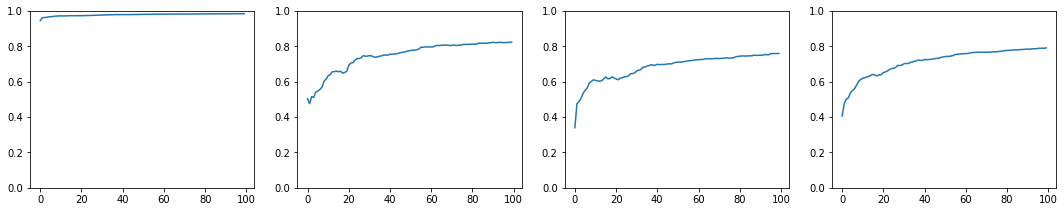

In [20]:
fig, axs = plt.subplots(1,4, figsize=(15,3))
axs[0].plot(acc_scores)
axs[1].plot(rec_scores)
axs[2].plot(prec_scores)
axs[3].plot(f1_scores)
fig.tight_layout()
[ax.set_ylim(0,1) for ax in axs]

In [24]:
ha_model = HA_model_v1(train_dataset, emulated_dataset_size=5885)
ha_preds = ha_model.predict_dataset(cur_infos=test_dataset.incident_info,
                         cur_input_data=None,
                         cur_input_data_time=test_dataset.input_time_data)
calc_metrics(y_hat=ha_preds,
             y=test_dataset.target_data,
             )

{'accuracy': tensor(0.9837),
 'f1': tensor(0.7902),
 'prec': tensor(0.7589),
 'rec': tensor(0.8241),
 'start_Mmape': tensor(0.3651),
 'end_Mmape': tensor(0.3720),
 'speed_Mmape': tensor(0.2408)}

In [ ]:
len = 2054

In [ ]:
np.random.choice(np.arange(len), size=100, replace=False)

array([1164,  276,  792,   44, 1908, 1973, 1699, 1480,  478,  411,  436,
       1623,    4, 1736, 1546, 2024,  143,  505,  290, 1270, 1323, 1167,
        604, 1168, 1750, 1843,  923, 1494, 1725, 1478, 1913, 1504, 1240,
       1365,  535,  187, 1461, 1715,  597,  875, 1006,   51, 1335,  753,
        531,  534,   86, 1872,  540,   35, 1165,  246, 1173, 1596,  648,
        151, 1037,  662, 1169,  959, 1507,  100,  236,   61, 1918, 1948,
       1030, 1819,  913, 1063,  152, 1104, 1771,  322, 1284, 1891, 1236,
         34,  270,  132,  126, 1785, 1957, 1182,  317,  895,   64,   22,
        200,  251,  159,  864, 1393,  901, 1470, 1149, 2049, 1363,  629,
        407])

In [ ]:
np.random.choice()

In [ ]:

best_indexes = [find_best_hist_inci(idx, val_dataset) for idx in range(val_dataset.incident_info.shape[0]) ]

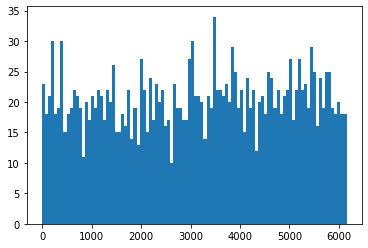

In [ ]:
plt.hist(np.stack(best_indexes), bins=100);

In [ ]:
train_dataset.target_data[best_indexes]

tensor([[[  0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000],
         ...,
         [  0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000]],

        [[  0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000],
         ...,
         [  0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000]],

        [[  0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000],
         ...,
         [  0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   0.0000]],

        ...,

        [[  0.0000, 

In [ ]:
# We select a random incident
inc_idx = np.random.randint(val_dataset.incident_info.shape[0])
inc_idx

1551

In [ ]:
target_inc_info = val_dataset.incident_info[inc_idx]
target_ie_idx = target_inc_info[0].int()
target_n_lanes = target_inc_info[1].int()
target_zone_speed = target_inc_info[2].int()
target_block_dur = target_inc_info[3].int()
target_ie_time = val_dataset.input_data_time[inc_idx,0,0,14,:]

In [ ]:
val_dataset.incidj

In [ ]:
best_indexes.shape

torch.Size([2054])

In [ ]:
val_dataset.incident_info.shape

torch.Size([2054, 4])

In [ ]:
val_dataset.input_data_time.shape

torch.Size([2054, 147, 6, 15, 2])

In [ ]:
combined_mask = find_best_hist_inci(inc_idx)

In [ ]:
train_ie_times = train_dataset.input_data_time[:,0,0,14,:]

In [ ]:
matching_ie_times = train_ie_times[combined_mask]


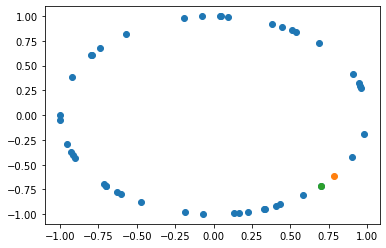

In [ ]:
plt.scatter(matching_ie_times[:,0], matching_ie_times[:,1])
plt.scatter(target_ie_time[0], target_ie_time[1])
plt.scatter(matching_ie_times[33,0], matching_ie_times[33,1])

In [ ]:
time_dists = torch.tensor([torch.linalg.vector_norm(target_ie_time - ie_time) for ie_time in matching_ie_times])

In [ ]:
time_dists.argmin()

tensor(33)

In [ ]:
torch.stack([find_best_hist_inci(idx) for idx in range(val_dataset.incident_info.shape[0])]

tensor(3)

In [ ]:
torch.linalg.vector_norm(torch.tensor([2.,0.]) + torch.tensor([0.,2.]), ord=2)

tensor(2.8284)

In [ ]:
np.sqrt(8)

2.8284271247461903